## YOLOv8

In [ ]:
from ipynb.fs.full.general_functions import *
from ultralytics import YOLO
import ipynb.fs.full.methods_names as methods


class YoloV8Models:
    model_v1 = None
    model_v2 = None
    model_v3 = None
    model_v4 = None
    #dataset novo
    model_v5 = None
    
    def load(trainVersion):
        if (trainVersion == 1):
            f = "v1-best-yolov8-newdataset-v2-300-seg.pt"
            if (YoloV8Models.model_v1 == None):
                print("Carrega "+f)
                YoloV8Models.model_v1 = YoloV8Models.__load(f)
            else:
                print("Usando "+f)
            return YoloV8Models.model_v1
        
        elif (trainVersion == 2):
            f = "v2-best-384-14h.pt"
            if (YoloV8Models.model_v2 == None):
                print("Carrega "+f)
                YoloV8Models.model_v2 = YoloV8Models.__load(f)
            else:
                print("Usando "+f)
            return YoloV8Models.model_v2
        
        elif (trainVersion == 3):
            f = "v3-best-416.pt"
            if (YoloV8Models.model_v3 == None):
                print("Carrega "+f)
                YoloV8Models.model_v3 = YoloV8Models.__load(f)
            else:
                print("Usando "+f)
            return YoloV8Models.model_v3
        
        elif (trainVersion == 4):
            f = "v4-4days-512.pt"
            if (YoloV8Models.model_v4 == None):
                print("Carrega "+f)
                YoloV8Models.model_v4 = YoloV8Models.__load(f)
            else:
                print("Usando "+f)
            return YoloV8Models.model_v4
    
        elif (trainVersion == 5):
            #usei o box e nao o segmentation
            #esta encontrando 68 celulas na primeira imagem
            f = "v5-1week-512.pt"
            if (YoloV8Models.model_v5 == None):
                print("Carrega "+f)
                YoloV8Models.model_v5 = YoloV8Models.__load(f)
            else:
                print("Usando "+f)
            return YoloV8Models.model_v5
        
    def __load(file):
        if os.path.isfile("./yolov8/%s" % file):
            return YOLO("./yolov8/%s" % file)
        else:
            return YOLO("./segmentation_methods/yolov8/%s" % file)


def yolov8_method(path, validation_type, mark_parasites=True, trainVersion = 5):
    """
    Returns: (img, cell_mask_colored), (cells, internal, external, passTime)
    """
    
    if (trainVersion == 1):
        name = methods.YOLOv1
    elif (trainVersion == 2):
        name = methods.YOLOv2
    elif (trainVersion == 3):
        name = methods.YOLOv3
    elif (trainVersion == 4):
        name = methods.YOLOv4
    elif (trainVersion == 5):
        name = methods.YOLOv5
    else:
        print("Versao invalida")
        
    method_ext = "_"+name
    
    start = time.time()
    
    #read in colors
    img = get_image(path=path,mode=1)
    
    model = YoloV8Models.load(trainVersion)
    
    results = model(path, conf=0.6 )
    
    #mark
    res = results[0]
    for box in res.boxes.xywhn:
        x,y,w,h = box
        
        x, y = x * img.shape[1], y * img.shape[0]
        w, h = w * img.shape[1], h * img.shape[0]
        
        x,y,w,h = int(x),int(y),int(w),int(h)
        img = cv2.circle(img, (x,y), 8, (200,0,0), -1)
    
    
    #mask
    cells = 0
    if res.masks == None:
        print("Falha, nao criou mascara")
        return False
    
    
    cell_mask = np.zeros_like(np.asarray(res.masks.data[0].cpu()), dtype='bool')
    for mask in res.masks.data:
        cells += 1
        mask = np.asarray(mask.cpu(), dtype='bool')
        cell_mask = np.ma.mask_or(cell_mask, mask )

    cell_mask = cell_mask.astype(np.uint8)
    
    
    #hsv mask
    par_mask, par_mask_dilated = hsv_par_mask(img)

    
    #Marca os parasitas
    cell_mask = cv2.resize(cell_mask,(640,480))
    if mark_parasites:
        img, internal, external = parasites_mark(img, par_mask, cell_mask)
    else:
        internal, external = 0,0
        
    end = time.time()
    
    img = cv2.resize(img, (640,480))
    cell_mask = cv2.resize(cell_mask, (640,480))

    passTime = "%.2fs" % (end-start)

    #save results
    save_results(path,name,cells,internal,external, passTime, img, method_ext, validation_type)
    
    return (img, cell_mask), (cells, internal, external, passTime)


if __name__ == '__main__':
    #PATH = "./PHOTOS_MALARIA_VHIR_UPC/fotos_2015_12_01/P_falciparum/Trofozoits/DSCN0083.JPG"
    #PATH = "../blood_samples/samples/blood_smear_2.JPG"
    #PATH = "../blood_samples/samples/blood_smear_15.JPG"
    #PATH = "../blood_samples/samples/blood_smear_14.JPG"
    PATH = '../blood_samples/samples/blood_smear_3.JPG'
    images, stats = yolov8_method(PATH, NO_VALIDATION, mark_parasites=True, trainVersion = 5)
    img, cell_mask = images
    cells, internal, external, passTime = stats 


    fig, ax = plt.subplots(ncols=2, figsize=(20, 20))
    ax[0].imshow(img)
    ax[0].set_title("%d Cells %d Internal %d External %s" %(cells,internal,external, passTime))
    ax[1].imshow(cell_mask, cmap='gray')
    ax[1].set_title("Cells segmentation")
    plt.show()

Carrega v5-1week-512.pt


image 1/1 C:\Users\alan_\Desktop\doc\pid-course-project\segmentation_methods\..\blood_samples\samples\blood_smear_3.JPG: 384x512 1 p-vivax trophozoite, 67 red blood cells, 46.0ms
Speed: 2.0ms preprocess, 46.0ms inference, 3.0ms postprocess per image at shape (1, 3, 512, 512)


> c:\users\alan_\appdata\local\temp\ipykernel_14484\1899099189.py(99)yolov8_method()

ipdb> result
*** NameError: name 'result' is not defined
ipdb> results
[ultralytics.yolo.engine.results.Results object with attributes:

boxes: ultralytics.yolo.engine.results.Boxes object
keypoints: None
keys: ['boxes']
masks: None
names: {0: 'difficult', 1: 'leukocyte', 2: 'p-vivax gametocyte', 3: 'p-vivax schizont', 4: 'p-vivax trophozoite', 5: 'red blood cell'}
orig_img: array([[[ 61, 100, 102],
        [ 58,  99, 101],
        [ 56, 100,  99],
        ...,
        [ 69,  88,  95],
        [ 69,  88,  95],
        [ 70,  89,  96]],

       [[ 58, 100,  99],
        [ 56,  98,  97],
        [ 57, 101, 100],
        ...,
        [ 71,  90,  97],
        [ 71,  90,  98],
        [ 70,  89,  97]],

       [[ 58, 100,  99],
        [ 56,  98,  97],
        [ 58, 103, 100],
        ...,
        [ 71,  90,  97],
        [ 73,  90,  99],
        [ 72,  89,  98]],

       ...,

       [[ 46,  79,  88],
   

WARNING  'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.


ultralytics.yolo.engine.results.Boxes object with attributes:

boxes: tensor([[1.4621e+03, 8.9361e+02, 1.6500e+03, 1.0810e+03, 9.6787e-01, 5.0000e+00],
        [7.9755e+02, 1.1269e+02, 9.9152e+02, 3.2207e+02, 9.5881e-01, 5.0000e+00],
        [1.8023e+03, 2.1442e-01, 2.0175e+03, 1.7973e+02, 9.5541e-01, 5.0000e+00],
        [1.4930e+02, 5.8987e+02, 3.3772e+02, 7.8436e+02, 9.5424e-01, 5.0000e+00],
        [1.0049e+03, 7.0786e+01, 1.1916e+03, 2.8059e+02, 9.5402e-01, 5.0000e+00],
        [7.5862e+02, 5.3736e+02, 9.3835e+02, 7.2945e+02, 9.5173e-01, 5.0000e+00],
        [1.2622e+03, 7.6261e+02, 1.4419e+03, 9.4412e+02, 9.5133e-01, 5.0000e+00],
        [2.1269e+03, 9.5283e+02, 2.3399e+03, 1.1428e+03, 9.5111e-01, 5.0000e+00],
        [1.7881e+03, 2.0199e+02, 1.9921e+03, 3.9723e+02, 9.5085e-01, 5.0000e+00],
        [1.6406e+03, 9.4369e+02, 1.8557e+03, 1.1505e+03, 9.5055e-01, 5.0000e+00],
        [8.7920e+02, 6.2111e+02, 1.0768e+03, 8.6863e+02, 9.5030e-01, 5.0000e+00],
        [6.1668e+02, 3.9687e

ipdb> results[0].data
*** AttributeError: 'Results' object has no attribute 'data'. See valid attributes below.

    A class for storing and manipulating inference results.

    Args:
        orig_img (numpy.ndarray): The original image as a numpy array.
        path (str): The path to the image file.
        names (dict): A dictionary of class names.
        boxes (torch.tensor, optional): A 2D tensor of bounding box coordinates for each detection.
        masks (torch.tensor, optional): A 3D tensor of detection masks, where each mask is a binary image.
        probs (torch.tensor, optional): A 1D tensor of probabilities of each class for classification task.
        keypoints (List[List[float]], optional): A list of detected keypoints for each object.


    Attributes:
        orig_img (numpy.ndarray): The original image as a numpy array.
        orig_shape (tuple): The original image shape in (height, width) format.
        boxes (Boxes, optional): A Boxes object containing the dete

Carrega v2-best-384-14h.pt


image 1/1 C:\Users\alan_\Desktop\doc\pid-course-project\segmentation_methods\..\blood_samples\samples\blood_smear_15.JPG: 288x384 111 cells, 23.0ms
Speed: 1.0ms preprocess, 23.0ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 384)


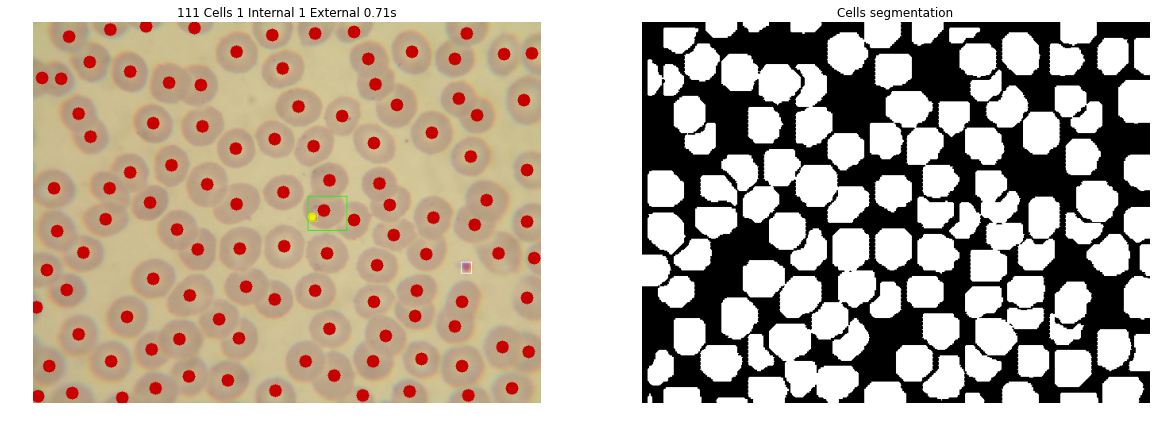

In [2]:
if __name__ == '__main__':
    #PATH = "./PHOTOS_MALARIA_VHIR_UPC/fotos_2015_12_01/P_falciparum/Trofozoits/DSCN0083.JPG"
    #PATH = "../blood_samples/samples/blood_smear_2.JPG"
    PATH = "../blood_samples/samples/blood_smear_15.JPG"
    #PATH = "../blood_samples/samples/blood_smear_14.JPG"
    #PATH = '../blood_samples/samples/blood_smear_3.JPG'
    images, stats = yolov8_method(PATH, NO_VALIDATION, mark_parasites=True, trainVersion = 2)
    img, cell_mask = images
    cells, internal, external, passTime = stats 


    fig, ax = plt.subplots(ncols=2, figsize=(20, 20))
    ax[0].imshow(img)
    ax[0].set_title("%d Cells %d Internal %d External %s" %(cells,internal,external, passTime))
    ax[1].imshow(cell_mask, cmap='gray')
    ax[1].set_title("Cells segmentation")
    plt.show()

Carrega v3-best-416.pt


image 1/1 C:\Users\alan_\Desktop\doc\pid-course-project\segmentation_methods\..\blood_samples\samples\blood_smear_15.JPG: 320x416 112 cells, 18.0ms
Speed: 2.0ms preprocess, 18.0ms inference, 13.0ms postprocess per image at shape (1, 3, 416, 416)


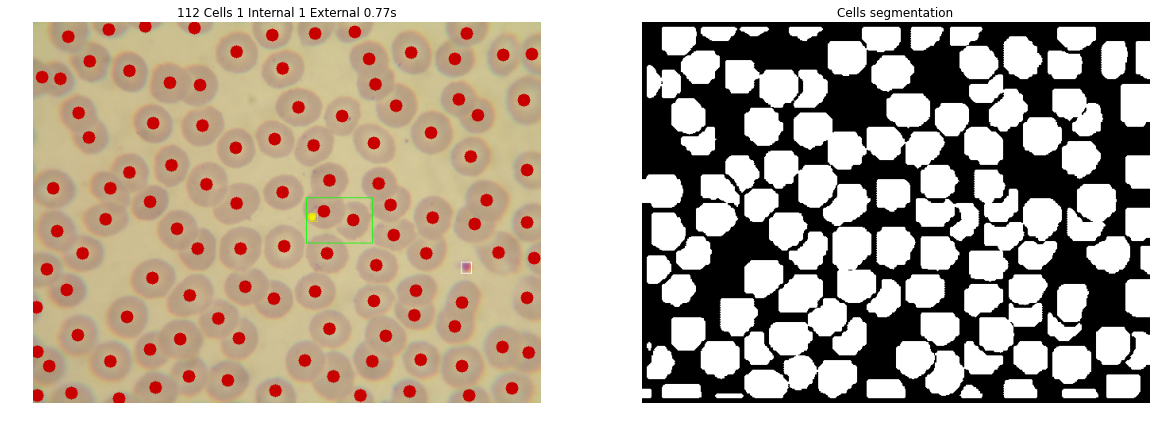

In [3]:
if __name__ == '__main__':
    #PATH = "./PHOTOS_MALARIA_VHIR_UPC/fotos_2015_12_01/P_falciparum/Trofozoits/DSCN0083.JPG"
    #PATH = "../blood_samples/samples/blood_smear_2.JPG"
    PATH = "../blood_samples/samples/blood_smear_15.JPG"
    #PATH = "../blood_samples/samples/blood_smear_14.JPG"
    #PATH = '../blood_samples/samples/blood_smear_3.JPG'
    images, stats = yolov8_method(PATH, NO_VALIDATION, mark_parasites=True, trainVersion = 3)
    img, cell_mask = images
    cells, internal, external, passTime = stats 


    fig, ax = plt.subplots(ncols=2, figsize=(20, 20))
    ax[0].imshow(img)
    ax[0].set_title("%d Cells %d Internal %d External %s" %(cells,internal,external, passTime))
    ax[1].imshow(cell_mask, cmap='gray')
    ax[1].set_title("Cells segmentation")
    plt.show()

Carrega v4-4days-512.pt



image 1/1 C:\Users\alan_\Desktop\doc\pid-course-project\segmentation_methods\..\blood_samples\samples\blood_smear_15.JPG: 384x512 112 cells, 34.0ms
Speed: 2.0ms preprocess, 34.0ms inference, 14.0ms postprocess per image at shape (1, 3, 512, 512)


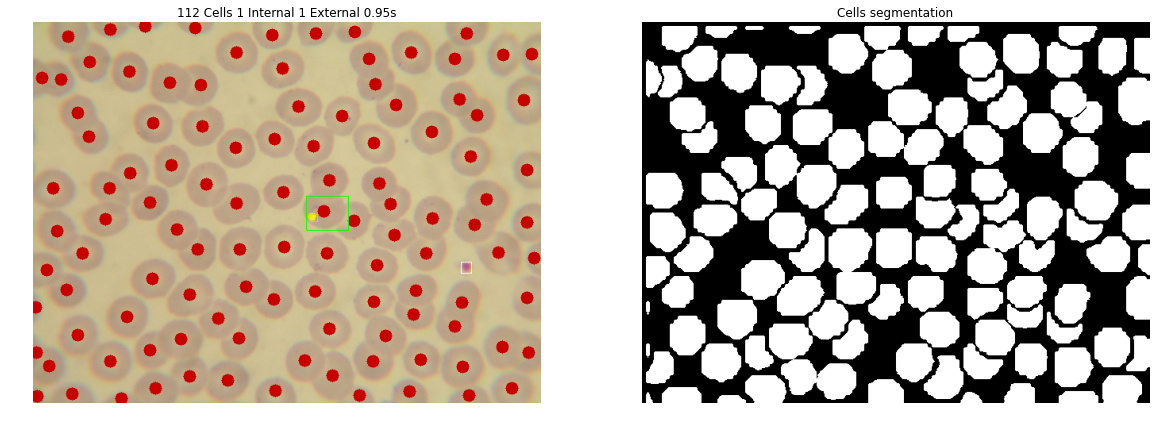

In [4]:
if __name__ == '__main__':
    #PATH = "./PHOTOS_MALARIA_VHIR_UPC/fotos_2015_12_01/P_falciparum/Trofozoits/DSCN0083.JPG"
    #PATH = "../blood_samples/samples/blood_smear_2.JPG"
    PATH = "../blood_samples/samples/blood_smear_15.JPG"
    #PATH = "../blood_samples/samples/blood_smear_14.JPG"
    #PATH = '../blood_samples/samples/blood_smear_3.JPG'
    images, stats = yolov8_method(PATH, NO_VALIDATION, mark_parasites=True, trainVersion = 4)
    img, cell_mask = images
    cells, internal, external, passTime = stats 


    fig, ax = plt.subplots(ncols=2, figsize=(20, 20))
    ax[0].imshow(img)
    ax[0].set_title("%d Cells %d Internal %d External %s" %(cells,internal,external, passTime))
    ax[1].imshow(cell_mask, cmap='gray')
    ax[1].set_title("Cells segmentation")
    plt.show()